In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# Clearing up memory
import gc

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score

# Bayesian Hyperparameter optimization
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK

# Utilities
import csv
import json
import ast
from timeit import default_timer as timer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [6]:
features = pd.read_csv('data/ft_2000_important.csv')
submit_base = pd.read_csv('data/test.csv')[['Id', 'idhogar']]

train = features[features['Target'].notnull()].copy()
test = features[features['Target'].isnull()].copy()

train_labels = np.array(train.pop('Target'))
test_ids = list(test.pop('idhogar'))

train, test = train.align(test, join = 'inner', axis = 1)

C:\Users\willk\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (572) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
for c in train:
    if train[c].dtype == 'object':
        train[c] = train[c].astype(np.float32)
        test[c] = test[c].astype(np.float32)

In [8]:
print('Train objects: ', train.columns[np.where(train.dtypes == 'object')])
print('Test objects: ', test.columns[np.where(test.dtypes == 'object')])

Train objects:  Index([], dtype='object')
Test objects:  Index([], dtype='object')


In [9]:
# missing_threshold = 0.95
# correlation_threshold = 0.99

# feature_matrix = feature_matrix.replace({np.inf: np.nan, -np.inf:np.nan})

# # One hot encoding (if necessary)
# feature_matrix = pd.get_dummies(feature_matrix)
# n_features_start = feature_matrix.shape[1]
# print('Original shape: ', feature_matrix.shape)

# # Find missing and percentage
# missing = pd.DataFrame(feature_matrix.isnull().sum())
# missing['fraction'] = missing[0] / feature_matrix.shape[0]
# missing.sort_values('fraction', ascending = False, inplace = True)

# # Missing above threshold
# missing_cols = list(missing[missing['fraction'] > missing_threshold].index)
# n_missing_cols = len(missing_cols)

# # Remove missing columns
# feature_matrix = feature_matrix[[x for x in feature_matrix if x not in missing_cols]]
# print('{} missing columns with threshold: {}.'.format(n_missing_cols, missing_threshold))

# # Zero variance
# unique_counts = pd.DataFrame(feature_matrix.nunique()).sort_values(0, ascending = True)
# zero_variance_cols = list(unique_counts[unique_counts[0] == 1].index)
# n_zero_variance_cols = len(zero_variance_cols)

# # Remove zero variance columns
# feature_matrix = feature_matrix[[x for x in feature_matrix if x not in zero_variance_cols]]
# print('{} zero variance columns.'.format(n_zero_variance_cols))

# # Correlations
# corr_matrix = feature_matrix.corr()

# # Extract the upper triangle of the correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# # Select the features with correlations above the threshold
# # Need to use the absolute value
# to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

# n_collinear = len(to_drop)

# feature_matrix = feature_matrix[[x for x in feature_matrix if x not in to_drop]]
# print('{} collinear columns removed with correlation above {}.'.format(n_collinear,  correlation_threshold))

# total_removed = n_missing_cols + n_zero_variance_cols + n_collinear

# print('Total columns removed: ', total_removed)
# print('Shape after feature selection: {}.'.format(feature_matrix.shape))

# # Remove columns derived from the Target
# drop_cols = []
# for col in feature_matrix:
#     if col == 'Target':
#         pass
#     else:
#         if 'Target' in col:
#             drop_cols.append(col)

# feature_matrix = feature_matrix[[x for x in feature_matrix if x not in drop_cols]]    

# # Extract out training and testing data
# train = feature_matrix[feature_matrix['Target'].notnull()]
# test = feature_matrix[feature_matrix['Target'].isnull()]

# train_labels = np.array(train.pop('Target')).reshape((-1, ))

## Custom Evaluation Metric

In [10]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

# Objective Function to Minimize (F1 Cross Validation Loss)

In [11]:
from IPython.display import display

In [12]:
display(f'{43 * 5}')

'215'

In [13]:
def objective(hyperparameters, nfolds=5):
    """Return validation score from hyperparameters for LightGBM"""
    
    # Keep track of evals
    global ITERATION
    ITERATION += 1
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Convert to arrays for indexing
    features = np.array(train)
    labels = np.array(train_labels).reshape((-1 ))
    
    valid_scores = []
    best_estimators = []
    run_times = []
    
    model = lgb.LGBMClassifier(**hyperparameters, class_weight = 'balanced',
                               n_jobs=-1, metric = 'None',
                               n_estimators=10000)
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        start = timer()
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score, 
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 400)
        end = timer()
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        best_estimators.append(model.best_iteration_)
        
        run_times.append(end - start)
    
    score = np.mean(valid_scores)
    score_std = np.std(valid_scores)
    loss = 1 - score
    
    run_time = np.mean(run_times)
    run_time_std = np.std(run_times)
    
    estimators = int(np.mean(best_estimators))
    hyperparameters['n_estimators'] = estimators
    
    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, score, score_std])
    of_connection.close()
    
    # Display progress
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {round(score, 4)}.')
    
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'time': run_time, 'time_std': run_time_std, 'status': STATUS_OK, 
            'score': score, 'score_std': score_std}

In [14]:
"""
Search Domain
"""

# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.025), np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 100000, 2000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0)
}

## Methods for Recording Results

* Trials object
* Writing to csv file

In [17]:
# Record results
trials = Trials()

# Create a file and open a connection
OUT_FILE = 'optimization3.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

MAX_EVALS = 100
PROGRESS = 10
N_FOLDS = 5
ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score', 'std']
writer.writerow(headers)
of_connection.close()

In [18]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

'Running Optimization for 100 Trials.'

'Iteration: 10, Current Score: 0.4444.'

'Iteration: 20, Current Score: 0.425.'

'Iteration: 30, Current Score: 0.4373.'

'Iteration: 40, Current Score: 0.4478.'

'Iteration: 50, Current Score: 0.4259.'

'Iteration: 60, Current Score: 0.4262.'

'Iteration: 70, Current Score: 0.433.'

'Iteration: 80, Current Score: 0.4419.'

'Iteration: 90, Current Score: 0.441.'

'Iteration: 100, Current Score: 0.4392.'

In [19]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(str(trials)))

print(best)

{'boosting_type': 1, 'colsample_by_tree': 0.9123205582882894, 'dart_subsample': 0.6016593237412641, 'learning_rate': 0.24688968283162896, 'min_child_samples': 60.0, 'num_leaves': 22.0, 'reg_alpha': 0.5117491903285334, 'reg_lambda': 0.5627049996653902, 'subsample_for_bin': 70000.0}


In [20]:
results = pd.read_csv(OUT_FILE)
results = results.sort_values('score', ascending = False).reset_index()
best_hyp = ast.literal_eval(results.loc[0, 'hyperparameters'])
results.to_csv('sorted_optimization3.csv', index = False)

In [21]:
best_hyp

{'boosting_type': 'dart',
 'colsample_bytree': 0.9123205582882894,
 'learning_rate': 0.24688968283162896,
 'min_child_samples': 60,
 'n_estimators': 78,
 'num_leaves': 22,
 'reg_alpha': 0.5117491903285334,
 'reg_lambda': 0.5627049996653902,
 'subsample': 0.6016593237412641,
 'subsample_for_bin': 70000}

In [22]:
del best_hyp['n_estimators']

In [23]:
def model_gbm(hyperparameters, features, labels, 
              test_features, test_ids, submission_base, 
              nfolds = 5, return_preds = False):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)
    
    # Model with hyperparameters selected from previous work
#     model = lgb.LGBMClassifier(boosting_type = 'gbdt', n_estimators = 10000, max_depth = -1,
#                                learning_rate = 0.025, metric = 'None', min_child_samples = 30,
#                                reg_alpha = 0.35, reg_lambda = 0.6, num_leaves = 15, 
#                                colsample_bytree = 0.85, objective = 'multiclass', 
#                                class_weight = 'balanced', 
#                                n_jobs = -1)

    model = lgb.LGBMClassifier(**hyperparameters, 
                               objective = 'multiclass', n_jobs = -1, 
                               n_estimators = 10000, metric = 'None')
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        # Dataframe for 
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        predictions = predictions.append(fold_predictions)
        
        importances += model.feature_importances_ / nfolds   
        
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances
    return submission, feature_importances, valid_scores

In [24]:
%%capture --no-display
submission, feature_importances, valid_scores = model_gbm(best_hyp, train, train_labels,
                                                          test, test_ids, submit_base)

'Fold 1, Validation Score: 0.45041, Estimators Trained: 53'

'Fold 2, Validation Score: 0.418, Estimators Trained: 111'

'Fold 3, Validation Score: 0.40178, Estimators Trained: 16'

'Fold 4, Validation Score: 0.39564, Estimators Trained: 168'

'Fold 5, Validation Score: 0.43907, Estimators Trained: 72'

'5 cross validation score: 0.42098 with std: 0.02104.'

In [25]:
def plot_feature_importances(df, n = 15, return_features = False, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'red', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    if return_features:
        return df

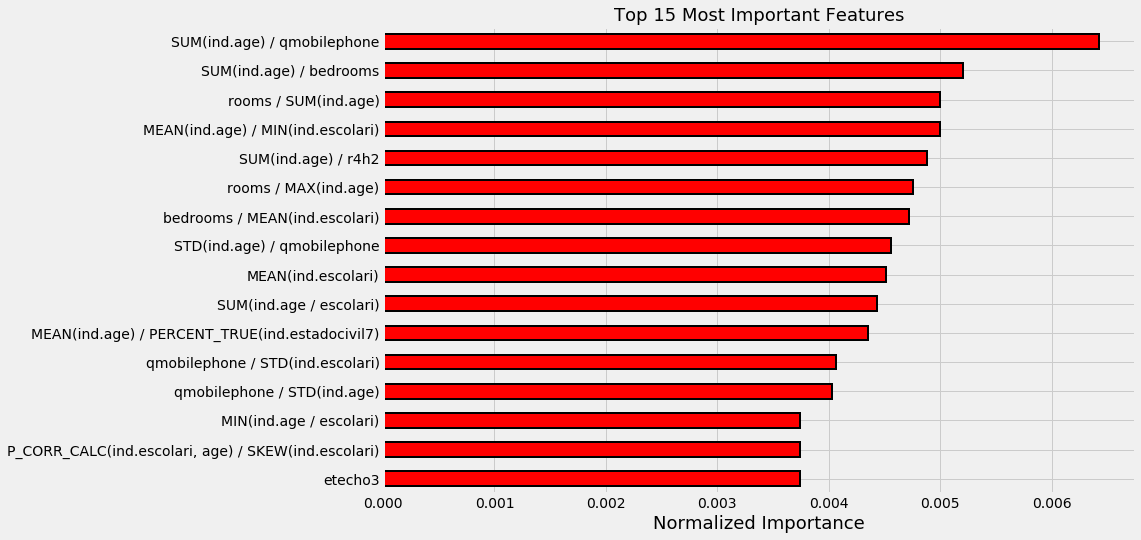

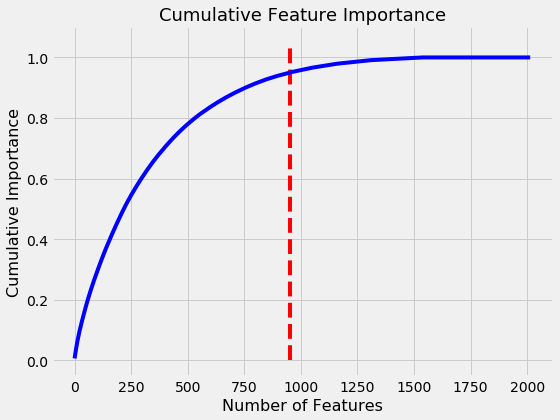

951 features required for 95% of cumulative importance.


In [26]:
plot_feature_importances(feature_importances, threshold = 0.95)

In [27]:
submission.to_csv('bayesian_optimization_submission.csv', index = False)